In [1]:
import pandas as pd
from Bio import SeqIO
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

###Exploration

In [2]:
training_output = pd.read_csv('./DREAM6_ExPred_PromoterActivities.txt', sep='\t', header=None)
training_output.columns = ['promoter', 'value']

In [3]:
training_output.head()

,promoter,value
0,RPL10,2.84
1,RPL11B,1.59
2,RPL12A,0.92
3,RPL13A,1.20
4,RPL13B,1.66


In [4]:
len(training_output)

90

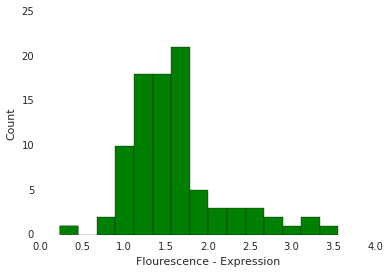

In [5]:
training_output.value.hist(bins=15, color='g')
plt.xlabel('Flourescence - Expression')
plt.ylabel('Count')
plt.savefig('./hist_training_data_flourescence.png')

In [6]:
testing_output = [float(x.strip().split('\t')[1]) for x in open('./dream6_expred_predictions_gold_standard_0.txt').readlines()[1:]]

In [7]:
testing_output[:10]

[0.89, 1.58, 1.62, 0.95, 2.33, 3.14, 0.56, 1.49, 1.24, 1.37]

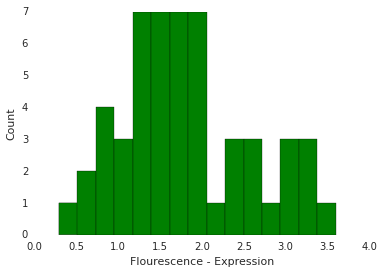

In [8]:
pd.Series(testing_output).hist(bins=15, color='g')
plt.xlabel('Flourescence - Expression')
plt.ylabel('Count')
plt.savefig('./hist_testing_data_flourescence.png')

ideas: Methylation levels (epigram), DNA Polymerase chipseq (?), motifs for transcription factors

###Create input for Meme-Suite

In [9]:
names, seqs = [], []
handle = open("./DREAM6_ExPred_Promoters.fasta", "rU")
for record in SeqIO.parse(handle, "fasta") :
    names.append(record.name)
    seqs.append(record.seq)
handle.close()

In [10]:
total = 0
for seq in seqs:
    total += len(seq)
    print total

450
1100
1782
2416
3135
4307
4613
5295
6260
6958
7622
8074
9205
9767
10132
10905
11512
12156
12583
13111
13573
14149
15016
15849
16404
17062
18191
19343
19973
21120
21780
22560
23353
23684
24112
24900
25494
26131
27184
27570
28189
28943
29435
30591
30804
31998
32500
33457
34382
34772
35122
36321
37101
37611
38084
38803
39608
40102
40693
41163
41693
42034
43184
43556
44272
44906
45917
46486
47013
47419
48024
48923
49546
49835
50732
51226
51691
52414
53101
53533
54087
54381
55561
56660
57442
58166
58879
60062
60629
61493


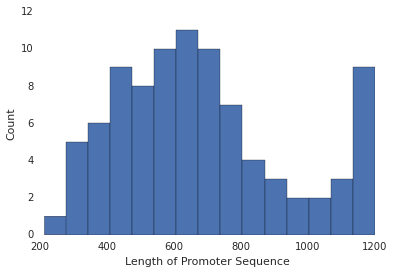

In [11]:
ax = pd.Series([len(x) for x in seqs]).hist(bins=15)
plt.xlabel('Length of Promoter Sequence')
plt.ylabel('Count')
plt.savefig('./hist_training_data_lengths.png')

In [12]:
with open('./training_promoters.4_90.fasta', 'w') as f:
    for i, name in enumerate(names[3:]):
        f.write('>{0}\n'.format(name))
        f.write('{0}\n'.format(seqs[i]))

Searching for 10 motifs of length 8 or 9

###Strip output file and consolidate into matrix

In [13]:
def get_info(in_file):
    lines = [x.strip() for x in open(in_file).readlines()]
    number_of_lines = len(lines)
    motifs = []
    sequences_with_motifs = []
    regular_expressions = []
    i = 0
    while i < number_of_lines:
        line = lines[i]
        if 'regular expression' in line:
            i += 2
            regular_expressions.append(lines[i])
        if 'Multilevel' in line:
            motif = line.split(' ')[-1]
            print motif
            motifs.append(motif)
            sequences_with_motif = []
            i += 11
            while lines[i][0] is not '-':
                sequences_with_motif.append(lines[i].split(' ')[0])
                i+=1
            sequences_with_motifs.append(sequences_with_motif)
        i+=1
    return motifs, sequences_with_motifs, regular_expressions

In [14]:
motifs1, sequences_with_motifs1, regular_expressions1 = get_info('./1_87.txt')
motifs2, sequences_with_motifs2, regular_expressions2 = get_info('./4_90.txt')

GTATGGGTG
TTTTTTTTC
ATGTATGGG
TTTTTTTTT
TCCGCCTAG
ATCCGTACA
TTTTTCAA
CCCGGCCC
GGCCCTGGC
TCGCGCGTC
GTATGGGTG
TTTTTTTTC
ATGTATGGG
TTTTTTTTT
TCCGCCTAG
ATCCGTACA
TTTTTCAA
CCCGGCCC
GGCCCTGGC
TCGCGCGTC


In [15]:
regular_expressions1

['GTA[TC]GG[GA]TG',
 'TTTTTTTTC',
 'ATGT[AG]TGGG',
 'TT[TC]TTTTTT',
 '[TG]C[CG]GCCT[AG][GC]',
 'ATC[CT]GTACA',
 'TTTTTC[AC]A',
 'CCCGGCCC',
 'GGCCCTGGC',
 '[TC][CG][GC]CGCGTC']

Somehow merge the the two files together

In [16]:
motifs = motifs1
sequences_with_motifs = sequences_with_motifs1
regular_expressions = regular_expressions1
for i, motif in enumerate(motifs2):
    if motif in motifs1:
        position = motifs1.index(motif)
        # need to only extend the difference between the two lists
        sequences_with_motifs[position].extend([x for x in sequences_with_motifs2[i] if x not in sequences_with_motifs[position]])
    else:
        motifs.append(motif)
        sequences_with_motifs.append(sequences_with_motifs2[i])
        regular_expressions.append(regular_expressions2[i])

In [17]:
print len(motifs)
print len(sequences_with_motifs)

10
10


In [18]:
matrix = [[0 for x in names] for y in motifs]
for y, seqs_with_motif in enumerate(sequences_with_motifs):
    for x, seq in enumerate(names):
        #matrix[y][x] = seqs_with_motif.count(seq)
        if seq in seqs_with_motif: 
            matrix[y][x] = 1
        else:
            matrix[y][x] = 0

In [19]:
with open('./training_matrix.binary.csv', 'w') as f:
    f.write(',{0}\n'.format(','.join(names)))
    for i, x in enumerate(matrix):
        f.write('{0},{1}\n'.format(regular_expressions[i], ','.join([str(k) for k in x])))

In [91]:
pd.read_csv('./training_matrix.csv', index_col=0)

,RPL10,RPL11B,RPL12A,RPL13A,RPL13B,RPL14A,RPL14B,RPL15A,RPL15B,RPL16B,...,RPS27B,RPS28B,RPS3,RPS4A,RPS4B,RPS6A,RPS6B,RPS7A,RPS7B,RPS9A
GTA[TC]GG[GA]TG,0,1,0,1,2,1,1,2,1,0,...,1,0,1,1,1,1,1,1,1,1
TTTTTTTTC,2,1,0,2,1,2,1,0,1,1,...,2,2,2,1,2,2,2,0,0,2
ATGT[AG]TGGG,0,1,1,1,1,1,1,0,0,1,...,1,1,0,1,1,1,0,1,1,0
TT[TC]TTTTTT,1,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
[TG]C[CG]GCCT[AG][GC],0,0,2,2,1,1,2,1,1,0,...,1,0,0,1,0,1,1,0,1,0
ATC[CT]GTACA,0,0,1,0,1,1,0,1,0,1,...,0,1,1,0,0,0,0,0,0,0
TTTTTC[AC]A,0,0,0,2,0,1,2,1,1,0,...,1,0,1,0,0,0,0,0,0,0
CCCGGCCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GGCCCTGGC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
[TC][CG][GC]CGCGTC,0,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


###Look for the motifs in test set

In [20]:
names, seqs = [], []
handle = open("./DREAM6_ExPred_TestSetPromoters.fasta", "rU")
for record in SeqIO.parse(handle, "fasta") :
    names.append(record.name)
    seqs.append(str(record.seq))
handle.close()

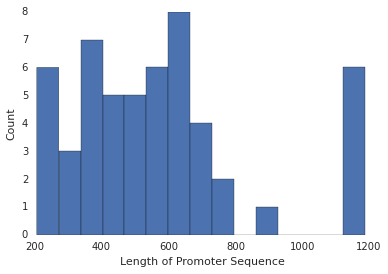

In [21]:
ax = pd.Series([len(x) for x in seqs]).hist(bins=15)
plt.xlabel('Length of Promoter Sequence')
plt.ylabel('Count')
plt.savefig('./hist_testing_data_lengths.png')

In [22]:
names[:5]

['RPL11A', 'RPL12B', 'RPL21A', 'RPL21B', 'RPL26A']

In [23]:
seqs[:2]

['GTTTGTTTTTTTTTCCTTCTTTTCTTTCTGGTTTCTTTCTATCTATTCAATTTAATAGTAAATTTGTTATTCTCTTTTGAAAATTGATATATTGAAGCCTTTCTTTACAATTCACCTTGCATTATTGAAGGAGTGCTATTCTTCGTTTTGCCACCCTTTTGCTGTTTTCCCTCATATCACATAATACCCGGAGAGGCTCTTTCCTGCGACAGCGCAACATCCAACCATCCTAAAGGTATGGGTGTACTGACGATGCGATTATTTCATTAAGTTCTGTCTTTTTTGTATAAATGAAAAAAGAACGGTGAAATCCATAGAAATACAGAGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACATCCACGTGACCAGTTTCCAATCGAACTTTTTCACTTTGCAGGGAATTATTGTTTCACTAGCAAAGGTAGCCCACTTACCACTCAGCTATGCGAAAGTTTCATTGTTTGATACATCTTGATAGTAACCGCAGGCTTCTTTCTTAGTTCATATTTTATTGTATTTCAACTAATATTATTTTTTTTTCAGTGGAAGGGAAGGTGAACCAAGAACATACAAACATAGCCAAAG',
 'TTTTTGGTGCGGCCTTCTGCAATTACTGATTAAGTAGCAATTTTCCTTCAAACATCCGTGCACTGTGGATGTTTGGGTTGTGTATTTTGCTTTCATAACATACAGATATTTTGTTTAAGGAAGTGAAATAAACAATATCATAAAACAGGTACTTCATAGACCATAAAGCATAACCCAGATTATCCTCTTAGATAGCAATGCTAATGTAAACAGAGATCCGTTTGCGTGACTTTATACTAATATGATATGTCTACTTCGCTTTGTGTTCGAGCAGCCTGGCAGTCCCCTCTAGCCGCTTTTTTCCCTTTCCGAAGGTTTCCGCCTAAGCCCCCTGGCTCTAGGCCGAGAAAATGTTAATGCTCCTTCTACGAGAAAATGCTTGTCGCCACACCA

In [24]:
matrix = [[0 for x in names] for y in regular_expressions]
for y, regex in enumerate(regular_expressions):
    for x, seq in enumerate(seqs):
        if len(re.findall(regex, seq)) > 0:
            matrix[y][x] = 1
        else:
            matrix[y][x] = 0
        #matrix[y][x] = len(re.findall(regex, seq))

###Output the test matrix

In [25]:
with open('./testing_matrix.binary.csv', 'w') as f:
    f.write(',{0}\n'.format(','.join(names)))
    for i, x in enumerate(matrix):
        f.write('{0},{1}\n'.format(regular_expressions[i], ','.join([str(k) for k in x])))

In [126]:
df = pd.read_csv('./testing_matrix.csv', index_col=0)

In [127]:
df.head()

,RPL11A,RPL12B,RPL21A,RPL21B,RPL26A,RPL28,RPL35B,RPL37A,RPL37B,RPL42A,...,RPL7B_Mut1,RPL7B_Mut2,RPL8A_Mut1,RPL8A_Mut2,RPL8A_Mut3,RPP1B_Mut1,RPS12_Mut1,RPS14B_Mut1,RPS20_Mut1,RPS9A_Mut1
GTA[TC]GG[GA]TG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTTTTTTC,2,0,0,0,1,0,1,1,1,0,...,0,0,1,1,1,0,0,0,0,0
ATGT[AG]TGGG,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TT[TC]TTTTTT,2,0,0,0,1,0,0,1,1,1,...,0,0,1,1,1,0,0,0,0,1
[TG]C[CG]GCCT[AG][GC],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
